In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA,TruncatedSVD,NMF
from sklearn.preprocessing import Normalizer
import argparse
import time
import dask
import pickle as pkl
import dask.dataframe as dd
import numba
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None
from functools import reduce
import matplotlib
#matplotlib.use('agg')
matplotlib.style.use('ggplot')
from matplotlib import pyplot as plt
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)

In [2]:
br_to_us=pd.read_excel("Book.xlsx",skiprows=[0])
br_to_us_dict=dict(zip(br_to_us.UK.tolist(),br_to_us.US.tolist()))
spelling_replacement={'modifier':br_to_us_dict,'head':br_to_us_dict}

In [3]:
def lemma_maker(x, y):
    #print(lemmatizer(x,y)[0])
    return lemmatizer(x,y)[0]

In [19]:
heads=pd.read_pickle("/data/dharp/compounding/datasets/heads_CompoundAware_0_20_300.pkl")
#heads.reset_index(inplace=True)
#heads=heads.drop(['decade'],axis=1).groupby(['head']).mean()
#heads=heads+1
#heads.index.set_names('time', level=1,inplace=True)
heads.info()
heads.head()

<class 'pandas.core.frame.DataFrame'>
Index: 108584 entries, a_noun to zywicki_noun
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 249.4+ MB


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
head,,,,,,,,,,,,,,,,,,,,,
a_noun,0.165,-0.066,0.080,0.018,0.294,0.251,0.034,-0.081,-0.079,-0.190,...,0.007,-0.035,-0.088,0.054,0.029,-0.118,-0.038,-0.045,-0.033,-0.118
aa_noun,0.024,0.003,0.028,0.009,0.112,0.117,0.005,-0.053,-0.056,-0.043,...,0.037,-0.045,-0.186,0.167,0.012,-0.054,-0.044,-0.082,0.113,0.002
aaa_noun,0.055,0.007,0.061,0.021,0.260,0.239,0.024,-0.084,-0.068,-0.163,...,-0.010,0.002,-0.037,0.119,0.076,-0.035,0.014,-0.099,-0.020,-0.070
aaboe_noun,0.001,0.000,0.004,0.001,0.016,0.014,-0.002,-0.007,-0.010,-0.006,...,-0.011,0.013,-0.022,0.040,0.000,0.019,-0.029,-0.009,-0.010,-0.015
aac_noun,0.000,-0.000,0.000,0.000,0.002,0.003,0.000,-0.001,-0.001,-0.004,...,0.105,-0.138,-0.128,0.111,-0.023,-0.140,0.057,-0.073,-0.054,-0.196


In [12]:
modifiers=pd.read_pickle("/data/dharp/compounding/datasets/modifiers_CompoundAware_0_20_300.pkl")
#heads.reset_index(inplace=True)
#heads=heads.drop(['decade'],axis=1).groupby(['head']).mean()
#modifiers=modifiers+1
#modifiers.index.set_names('time', level=1,inplace=True)
modifiers.info()
modifiers.head()

<class 'pandas.core.frame.DataFrame'>
Index: 90565 entries, a_noun to zzzz_noun
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 208.0+ MB


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
modifier,,,,,,,,,,,,,,,,,,,,,
a_noun,0.068,-0.020,0.135,-0.044,0.212,0.110,0.081,-0.049,-0.029,-0.096,...,-0.005,-0.032,-0.102,0.111,0.007,-0.232,0.013,-0.061,-0.040,-0.201
aa_noun,0.075,0.050,0.059,0.022,0.230,0.091,0.125,-0.042,-0.052,-0.101,...,-0.028,0.026,-0.112,0.112,0.020,-0.178,-0.050,-0.074,-0.074,-0.165
aaa_noun,0.013,0.001,0.098,-0.061,0.068,0.067,-0.001,-0.019,-0.023,-0.036,...,-0.012,-0.042,-0.075,0.046,0.022,-0.190,-0.044,-0.041,-0.024,-0.183
aaaa_noun,0.000,0.000,0.000,0.000,0.006,0.004,-0.002,-0.001,-0.002,-0.005,...,0.004,-0.055,-0.203,0.173,0.118,-0.341,-0.057,-0.154,-0.110,-0.423
aaaaa_noun,0.000,0.000,0.000,0.000,0.006,0.004,-0.002,-0.001,-0.002,-0.005,...,0.004,-0.055,-0.203,0.173,0.118,-0.341,-0.057,-0.154,-0.110,-0.423


In [22]:
compounds=pd.read_pickle("/data/dharp/compounding/datasets/compounds_CompoundAware_0_20_300.pkl")
#heads.reset_index(inplace=True)
#heads=heads.drop(['decade'],axis=1).groupby(['head']).mean()
#compounds.index.set_names('time', level=2,inplace=True)
compounds.drop(['common'],axis=1,inplace=True)
#compounds=compounds+1
#compounds.reset_index(inplace=True)
compounds.info()
compounds.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1107332 entries, (a_noun, aaaaa_noun) to (zzzz_noun, best_noun)
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 2.5+ GB


0      1     2     3     4     5      6      7    \
modifier head                                                              
a_noun   aaaaa_noun   0.000  0.000 0.000 0.000 0.006 0.004 -0.002 -0.001   
         addison_noun 0.001 -0.000 0.032 0.006 0.014 0.015 -0.002 -0.006   
         anti_noun    0.000  0.000 0.000 0.000 0.004 0.005  0.000 -0.002   
         archive_noun 0.003 -0.001 0.002 0.001 0.014 0.019  0.003 -0.013   
         atom_noun    0.121  0.016 0.121 0.040 0.492 0.507  0.030 -0.154   

                         8      9    ...    290    291    292    293    294  \
modifier head                        ...                                      
a_noun   aaaaa_noun   -0.002 -0.005  ...  0.004 -0.055 -0.203  0.173  0.118   
         addison_noun -0.001 -0.011  ... -0.014  0.072  0.014 -0.052 -0.111   
         anti_noun    -0.002 -0.005  ...  0.010 -0.047 -0.162  0.149  0.090   
         archive_noun  0.021  0.002  ...  0.007 -0.011 -0.011  0.001  0.009   
         atom_noun    -0.150 -0.351  ... -0.009 -0.002  0.006 -0.011 -0.015   

                         295    296    297    298    299  
modifier head                                             
a_noun   aaaaa_noun   -0.341 -0.057 -0.154 -0.110 -0.423  
         addison_noun -0.129 -0.065 -0.043 -0.210 -0.038  
         anti_noun    -0.292 -0.019 -0.131 -0.048 -0.284  
         archive_noun  0.004  0.008 -0.010  0.002  0.003  
         atom_noun     0.005 -0.001 -0.001 -0.028  0.018  

[5 rows x 300 columns]

In [25]:
compounds.xs('best_noun', level=1, drop_level=False)

,,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
modifier,head,,,,,,,,,,,,,,,,,,,,,
abc_noun,best_noun,0.002,0.001,0.012,0.004,0.022,0.020,-0.004,-0.005,-0.015,-0.007,...,-0.014,-0.023,0.035,0.015,0.045,0.024,-0.017,-0.024,0.035,-0.064
ala_noun,best_noun,0.014,0.002,0.020,0.007,0.064,0.060,-0.000,-0.019,-0.019,-0.044,...,-0.052,0.026,-0.007,0.043,-0.026,0.021,-0.004,-0.065,0.045,0.035
american_noun,best_noun,0.000,0.000,0.001,0.000,0.011,0.012,-0.000,-0.005,-0.005,-0.014,...,0.017,-0.020,-0.002,-0.015,-0.016,-0.019,-0.005,-0.012,0.007,0.035
arkansa_noun,best_noun,0.095,0.012,0.079,0.024,0.411,0.557,0.031,0.439,-0.017,0.045,...,-0.002,-0.026,0.016,-0.040,-0.026,-0.010,-0.013,-0.015,-0.027,0.029
breed_noun,best_noun,0.002,0.000,0.023,0.002,0.022,0.019,-0.002,-0.011,-0.011,-0.012,...,-0.041,0.153,-0.219,0.033,0.037,-0.018,-0.079,0.050,-0.105,-0.138
captain_noun,best_noun,0.000,0.000,0.000,0.000,0.007,0.004,0.003,0.000,-0.002,-0.004,...,0.003,-0.001,-0.008,-0.003,0.006,0.005,0.006,0.005,-0.003,-0.005
charle_noun,best_noun,0.001,0.000,0.001,0.001,0.011,0.002,-0.002,-0.001,-0.002,-0.005,...,-0.059,-0.005,-0.029,0.019,0.006,0.132,-0.063,0.117,0.027,0.131
construction_noun,best_noun,0.003,-0.000,0.003,0.001,0.013,0.013,-0.001,-0.005,-0.005,-0.009,...,-0.014,0.075,0.004,-0.056,-0.025,-0.034,-0.025,0.061,0.039,0.044
deborah_noun,best_noun,0.000,0.000,0.001,0.000,0.004,0.004,0.000,-0.001,-0.001,-0.004,...,0.028,-0.002,-0.017,-0.008,0.001,-0.041,-0.013,-0.022,-0.008,-0.027


In [24]:
heads.reindex(compounds.index,level=1)

0      1     2      3     4      5    \
modifier           head                                                       
a_noun             aaaaa_noun          nan    nan   nan    nan   nan    nan   
                   addison_noun      0.086  0.002 0.104  0.025 0.309  0.323   
                   anti_noun         0.063 -0.028 0.204 -0.018 0.128 -0.057   
                   archive_noun      0.136 -0.071 0.028 -0.004 0.057  0.047   
                   atom_noun         0.045 -0.004 0.031  0.010 0.137  0.142   
                   b_noun            0.114 -0.018 0.078  0.025 0.322  0.318   
                   bachelor_noun     0.027  0.003 0.105  0.012 0.111  0.115   
                   backward_noun     0.083  0.010 0.108  0.028 0.347  0.345   
                   ballet_noun       0.013 -0.000 0.138  0.065 0.046  0.046   
                   balloon_noun      0.037  0.001 0.033  0.011 0.146  0.148   
                   band_noun         0.206 -0.059 0.110  0.028 0.431  0.417   
                   bar_noun          0.243 -0.166 0.035  0.007 0.121  0.108   
                   baseball_noun     0.033  0.009 0.046  0.010 0.166  0.148   
                   beginner_noun     0.079  0.010 0.088  0.030 0.345  0.330   
                   behavior_noun     0.045 -0.005 0.039  0.008 0.146  0.127   
                   bell_noun         0.043  0.003 0.050  0.015 0.176  0.173   
                   belle_noun        0.072  0.008 0.094  0.028 0.299  0.304   
                   bend_noun         0.028 -0.003 0.070  0.027 0.111  0.105   
                   better_noun       0.033  0.004 0.027  0.008 0.134  0.141   
                   bibliography_noun 0.071  0.046 0.285 -0.191 0.187  0.041   
                   bill_noun         0.123 -0.000 0.109  0.019 0.395  0.395   
                   biographical_noun 0.041  0.001 0.587 -0.501 0.001  0.002   
                   bird_noun         0.217 -0.086 0.100  0.011 0.369  0.331   
                   black_noun        0.060  0.017 0.177 -0.104 0.187  0.136   
                   blake_noun        0.015  0.003 0.018  0.006 0.066  0.062   
                   board_noun        0.588 -0.421 0.068  0.020 0.089  0.074   
                   book_noun         0.124  0.011 0.151 -0.003 0.368  0.259   
                   boswell_noun      0.027  0.004 0.030  0.010 0.113  0.117   
                   boy_noun          0.089  0.010 0.121  0.024 0.371  0.380   
                   brand_noun        0.318  0.273 0.133  0.016 0.457  0.455   
...                                    ...    ...   ...    ...   ...    ...   
zweiten_noun       von_noun          0.112 -0.037 0.067  0.024 0.248  0.236   
zwemmer_noun       gallery_noun      0.016  0.001 0.083 -0.021 0.073  0.064   
zwi_noun           werblowsky_noun   0.000  0.000 0.000  0.000 0.003  0.004   
zwickau_noun       prophet_noun      0.019  0.002 0.021  0.006 0.076  0.078   
zwicky_noun        catalog_noun      0.008  0.002 0.007  0.002 0.019  0.015   
zwiener_noun       wage_noun         0.058  0.016 0.036  0.011 0.168  0.168   
zwinglische_noun   reformation_noun  0.106  0.013 0.135  0.009 0.424  0.435   
zwischen_noun      himmel_noun       0.000 -0.000 0.002 -0.002 0.012  0.007   
                   weissem_noun      0.000 -0.000 0.004 -0.003 0.012 -0.000   
zwitterion_noun    form_noun         0.101 -0.001 0.100  0.023 0.348  0.346   
                   intermediate_noun 0.015 -0.002 0.031 -0.013 0.116 -0.002   
                   mechanism_noun    0.076  0.008 0.076  0.020 0.329  0.311   
                   route_noun        0.027 -0.001 0.046 -0.011 0.124  0.061   
zwolf_noun         stamme_noun       0.004  0.000 0.003  0.001 0.027  0.024   
zycie_noun         gospodarcze_noun  0.001 -0.000 0.046  0.025 0.010  0.010   
                   warszawy_noun     0.001  0.000 0.021  0.002 0.017  0.020   
zygapophyseal_noun joint_noun        0.112 -0.003 0.098  0.033 0.407  0.399   
zygmunt_noun       bauman_noun       0.058  0.007 0.051  0.016 0.231  0.240   
          

In [28]:
constituent_sim=compounds.reset_index()[['modifier','head']].merge(modifiers.reset_index(),how='left',on=['modifier'])
constituent_sim.set_index(['modifier','head'],inplace=True)


constituent_sim=constituent_sim.multiply(heads.reindex(constituent_sim.index, level=1).ffill()).sum(axis=1).to_frame()
constituent_sim.columns=['sim_bw_constituents']
constituent_sim.sim_bw_constituents.describe()

count   1107332.000
mean          0.202
std           0.191
min          -0.310
25%           0.064
50%           0.142
75%           0.280
max           1.000
Name: sim_bw_constituents, dtype: float64

In [38]:
compound_decade_counts=compounds.drop(['modifier','head'],axis=1).groupby('time').sum().sum(axis=1).to_frame()
compound_decade_counts.columns=['N']
compound_decade_counts

,N
time,
1800,5.549473e+06
1810,7.238801e+06
1820,1.060945e+07
1830,1.281525e+07
1840,1.552840e+07
1850,2.288116e+07
1860,2.249154e+07
1870,2.695524e+07
1880,3.556327e+07


In [39]:
compounds = dd.from_pandas(compounds, npartitions=30)

In [41]:
XY=compounds.groupby(['modifier','head','time']).sum().sum(axis=1).to_frame()
XY=XY.compute()
XY.columns=['a']

X_star=compounds.groupby(['modifier','time']).sum().sum(axis=1).to_frame()
X_star=X_star.compute()
X_star.columns=['x_star']

Y_star=compounds.groupby(['head','time']).sum().sum(axis=1).to_frame()
Y_star=Y_star.compute()
Y_star.columns=['star_y']


merge1=pd.merge(XY.reset_index(),X_star.reset_index(),on=['modifier','time'])
information_feat=pd.merge(merge1,Y_star.reset_index(),on=['head','time'])

information_feat=dd.from_pandas(information_feat, npartitions=30)
information_feat['b']=information_feat['x_star']-information_feat['a']
information_feat['c']=information_feat['star_y']-information_feat['a']


information_feat=information_feat.compute()
information_feat=pd.merge(information_feat,compound_decade_counts.reset_index(),on=['time'])
information_feat=dd.from_pandas(information_feat, npartitions=30)
information_feat['d']=information_feat['N']-(information_feat['a']+information_feat['b']+information_feat['c'])
information_feat['x_bar_star']=information_feat['N']-information_feat['x_star']
information_feat['star_y_bar']=information_feat['N']-information_feat['star_y']
#information_feat['LR']=-2*np.sum(information_feat['a']*np.log2((information_feat['a']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y'])))

information_feat=information_feat.compute()
information_feat.set_index(['modifier','head','time'],inplace=True)

information_feat.replace(0,0.0001,inplace=True)
information_feat['log_ratio']=2*(information_feat['a']*np.log((information_feat['a']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y']))+\
information_feat['b']*np.log((information_feat['b']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y_bar']))+\
information_feat['c']*np.log((information_feat['c']*information_feat['N'])/(information_feat['x_bar_star']*information_feat['star_y']))+\
information_feat['d']*np.log((information_feat['d']*information_feat['N'])/(information_feat['x_bar_star']*information_feat['star_y_bar'])))
information_feat['ppmi']=np.log2((information_feat['a']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y']))
information_feat['local_mi']=information_feat['a']*information_feat['ppmi']
information_feat.ppmi.loc[information_feat.ppmi<=0]=0
information_feat.drop(['a','x_star','star_y','b','c','d','N','d','x_bar_star','star_y_bar'],axis=1,inplace=True)
information_feat.info()
information_feat.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3781847 entries, (a_n, aaaaa_n, 1960) to (zone_n, homologue_n, 1930)
Data columns (total 3 columns):
log_ratio    float64
ppmi         float64
local_mi     float64
dtypes: float64(3)
memory usage: 119.8+ MB


log_ratio       ppmi     local_mi
modifier    head      time                                     
a_n         aaaaa_n   1960  4688.680508  11.235255  3380.718051
            addison_n 1960  2465.855716   7.322377  2192.017030
adherents_n addison_n 1960  5270.028489  13.558423  4087.861644
college_n   addison_n 1960  1847.026551   5.818874  1741.930201
conceits_n  addison_n 1960  5277.161324  13.562827  4092.725435

In [65]:
modifier_denom=np.square(modifiers).sum(axis=1)**0.5
modifier_denom=modifier_denom.to_frame()
modifier_denom.columns=['modifier_denom']
modifier_denom.info()
modifier_denom.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 514067 entries, (a_n, 1800) to (zylobalsamum_n, 1990)
Data columns (total 1 columns):
modifier_denom    514067 non-null float64
dtypes: float64(1)
memory usage: 9.3+ MB


modifier_denom
modifier time                
a_n      1800             1.0
         1810             1.0
         1820             1.0
         1830             1.0
         1840             1.0

In [66]:
head_denom=np.square(heads).sum(axis=1)**0.5
head_denom=head_denom.to_frame()
head_denom.columns=['head_denom']
head_denom.info()
head_denom.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 586758 entries, (a_n, 1800) to (zygote_n, 1990)
Data columns (total 1 columns):
head_denom    586758 non-null float64
dtypes: float64(1)
memory usage: 10.2+ MB


head_denom
head time            
a_n  1800         1.0
     1810         1.0
     1820         1.0
     1830         1.0
     1840         1.0

In [69]:
compound_denom=np.square(compounds.set_index(['modifier','head','time'])).sum(axis=1)**0.5
compound_denom=compound_denom.to_frame()
compound_denom.columns=['compound_denom']
compound_denom.info()
compound_denom.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3781847 entries, (a_n, aaaaa_n, 1960) to (zylobalsamum_n, process_n, 1920)
Data columns (total 1 columns):
compound_denom    float64
dtypes: float64(1)
memory usage: 62.1+ MB


compound_denom
modifier head      time                
a_n      aaaaa_n   1960             1.0
                   1970             1.0
                   1980             1.0
                   1990             1.0
         addison_n 1960             1.0

In [83]:
#compounds.drop('head',axis=1).set_index(['modifier','time']).multiply(modifiers)
compound_modifier_sim=compounds.multiply(modifiers.drop('mod_count',axis=1).reindex(compounds.index, method='ffill')).sum(axis=1).to_frame()
compound_modifier_sim.columns=['sim_with_modifier']
compound_modifier_sim.info()
compound_modifier_sim.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3781847 entries, (a_n, aaaaa_n, 1960) to (zylobalsamum_n, process_n, 1920)
Data columns (total 1 columns):
sim_with_modifier    float64
dtypes: float64(1)
memory usage: 67.1+ MB


sim_with_modifier
modifier head      time                   
a_n      aaaaa_n   1960             -0.002
                   1970              0.879
                   1980              0.879
                   1990              0.879
         addison_n 1960              0.008

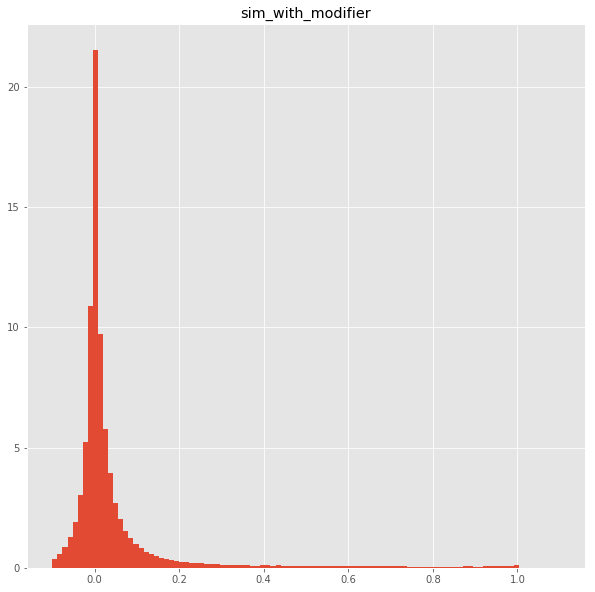

In [86]:
_=compound_modifier_sim.hist(column ='sim_with_modifier', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.1,1.1))

In [88]:
compound_head_sim=compounds.multiply(heads.reindex(compounds.index, method='ffill')).sum(axis=1).to_frame()
compound_head_sim.columns=['sim_with_head']
compound_head_sim.info()
compound_head_sim.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3781847 entries, (a_n, aaaaa_n, 1960) to (zylobalsamum_n, process_n, 1920)
Data columns (total 1 columns):
sim_with_head    float64
dtypes: float64(1)
memory usage: 67.1+ MB


sim_with_head
modifier head      time               
a_n      aaaaa_n   1960         -0.009
                   1970         -0.027
                   1980         -0.027
                   1990         -0.027
         addison_n 1960         -0.014

In [89]:
compound_head_sim.sim_with_head.describe()

count   3781847.000
mean          0.042
std           0.141
min          -0.682
25%          -0.004
50%           0.002
75%           0.030
max           1.000
Name: sim_with_head, dtype: float64

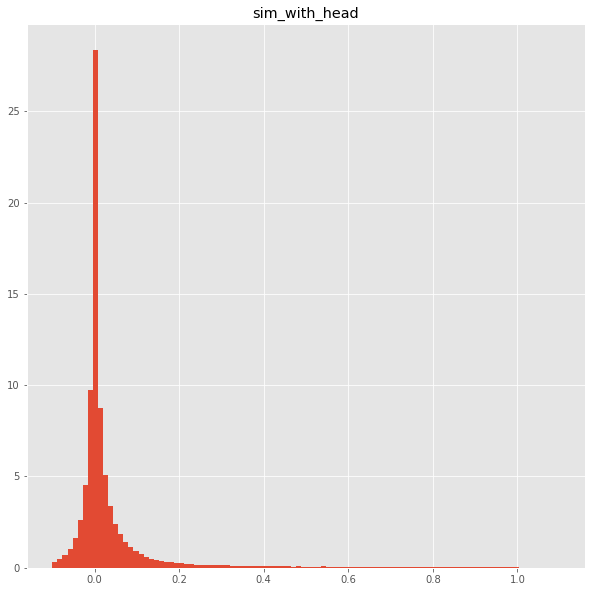

In [90]:
_=compound_head_sim.hist(column ='sim_with_head', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.1,1.1))

In [114]:
constituent_sim=compounds.reset_index()[['modifier','head','time']].merge(modifiers.reset_index(),how='left',on=['modifier','time'])
constituent_sim.set_index(['modifier','head','time'],inplace=True)
constituent_sim=constituent_sim.multiply(heads.reindex(constituent_sim.index, method='ffill')).sum(axis=1).to_frame()
constituent_sim.columns=['sim_bw_constituents']

In [115]:
constituent_sim.sim_bw_constituents.describe()

count   3781847.000
mean          0.112
std           0.211
min          -0.487
25%           0.000
50%           0.017
75%           0.102
max           1.000
Name: sim_bw_constituents, dtype: float64

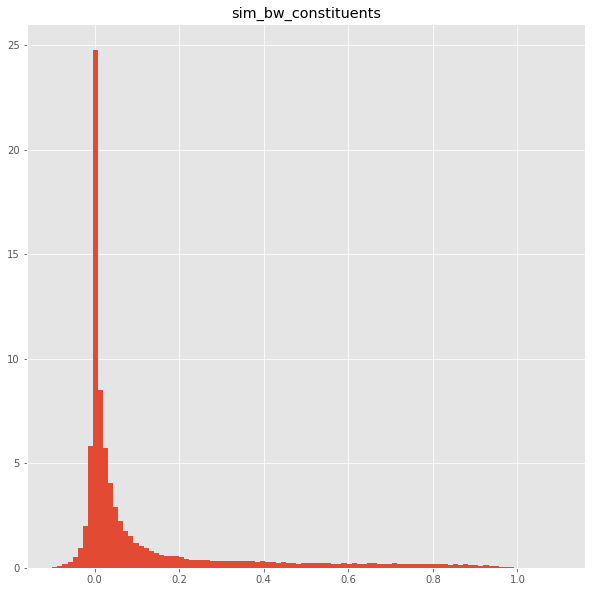

In [116]:
_=constituent_sim.hist(column ='sim_bw_constituents', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.1,1.1))

In [145]:
dfs = [constituent_sim, compound_head_sim, compound_modifier_sim, information_feat]
compounds_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs)
compounds_final=pd.pivot_table(compounds_final.reset_index(), index=['modifier','head'], columns=['time'])
compounds_final.fillna(0,inplace=True)
compounds_final -= compounds_final.min()
compounds_final /= compounds_final.max()
compounds_final_1=compounds_final.columns.get_level_values(0)
compounds_final_2=compounds_final.columns.get_level_values(1)

cur_year=0
new_columns=[]
for year in compounds_final_2:
    new_columns.append(str(year)+"_"+compounds_final_1[cur_year])
    cur_year+=1
compounds_final.columns=new_columns
compounds_final

1800_local_mi  1810_local_mi  1820_local_mi  \
modifier        head                                                          
a_n             aaaaa_n                 0.083          0.082          0.101   
                addison_n               0.083          0.082          0.101   
                anti_n                  0.083          0.082          0.101   
                archive_n               0.083          0.082          0.101   
                atom_n                  0.083          0.082          0.101   
                b_n                     0.566          0.611          0.586   
                ballet_n                0.083          0.082          0.101   
                band_n                  0.083          0.082          0.101   
                baseball_n              0.083          0.082          0.101   
                behavior_n              0.083          0.082          0.101   
                bell_n                  0.083          0.082          0.101   
                belle_n                 0.083          0.082          0.101   
                bend_n                  0.083          0.082          0.101   
                berkley_n               0.083          0.082          0.101   
                bibliography_n          0.083          0.082          0.101   
                bill_n                  0.083          0.082          0.101   
                bird_n                  0.083          0.082          0.101   
                board_n                 0.083          0.082          0.101   
                book_n                  0.083          0.082          0.101   
                boswell_n               0.083          0.082          0.101   
                brand_n                 0.083          0.082          0.101   
                briefe_n                0.083          0.082          0.101   
                bunch_n                 0.083          0.082          0.101   
                burn_n                  0.083          0.082          0.101   
                business_n              0.083          0.082          0.101   
                c_n                     0.613          0.656          0.623   
                calendar_n              0.083          0.082          0.101   
                call_n                  0.083          0.082          0.101   
                campaign_n              0.083          0.082          0.101   
                candle_n                0.083          0.082          0.101   
...                                       ...            ...            ...   
zuni_n          mountain_n              0.083          0.082          0.101   
                origin_n                0.083          0.082          0.101   
                prehistory_n            0.083          0.082          0.101   
                religion_n              0.083          0.082          0.101   
                ruin_n                  0.083          0.082          0.101   
                sacred_n                0.083          0.082          0.101   
                social_n                0.083          0.082          0.101   
                tradition_n             0.083          0.082          0.101   
                tribe_n                 0.083          0.082          0.101   
                village_n               0.083          0.082          0.101   
                war_n                   0.083          0.082          0.101   
                word_n                  0.083          0.082          0.101   
zunyi_n         conference_n            0.083          0.082          0.101   
zurich_n        acm_n                   0.083          0.082          0.101   
                agreement_n             0.083          0.082          0.101   
                chamber_n               0.083          0.082          0.101   
                conference_n            0.083          0.082          0.101   
                government_n            0.083          0.082          0.101   
   

In [159]:
reddy11_study=pd.read_csv("/data/dharp/compounding/datasets/ijcnlp_compositionality_data/MeanAndDeviations.clean.txt",sep="\t")
#print(reddy11_study.columns)
reddy11_study.columns=['compound','to_divide']
reddy11_study['modifier_mean'],reddy11_study['modifier_std'],reddy11_study['head_mean'],reddy11_study['head_std'],reddy11_study['compound_mean'],reddy11_study['compound_std'],_=reddy11_study.to_divide.str.split(" ",7).str
reddy11_study['modifier'],reddy11_study['head']=reddy11_study['compound'].str.split(" ",2).str
reddy11_study.modifier=reddy11_study.modifier.str[:-2]
reddy11_study['head']=reddy11_study['head'].str[:-2]
reddy11_study.drop(['compound','to_divide'],axis=1,inplace=True)
reddy11_study['modifier']=np.vectorize(lemma_maker)(reddy11_study['modifier'],'noun')
reddy11_study['head']=np.vectorize(lemma_maker)(reddy11_study['head'],'noun')
reddy11_study.replace(spelling_replacement,inplace=True)
reddy11_study['modifier']=reddy11_study['modifier']+"_n"
reddy11_study['head']=reddy11_study['head']+"_n"
reddy11_study=reddy11_study.apply(pd.to_numeric, errors='ignore')
#reddy11_study.set_index(['modifier','head'],inplace=True)
reddy11_study.info()
reddy11_study.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 8 columns):
modifier_mean    90 non-null float64
modifier_std     90 non-null float64
head_mean        90 non-null float64
head_std         90 non-null float64
compound_mean    90 non-null float64
compound_std     90 non-null float64
modifier         90 non-null object
head             90 non-null object
dtypes: float64(6), object(2)
memory usage: 5.7+ KB


,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,modifier,head
0,3.867,1.118,4.867,0.340,4.250,0.871,end_n,user_n
1,1.607,1.655,1.893,1.496,1.704,1.717,firing_n,line_n
2,2.821,1.965,4.862,0.345,3.828,1.234,game_n,plan_n
3,4.767,0.423,4.862,0.345,4.800,0.476,application_n,form_n
4,0.600,0.800,4.586,1.099,1.310,1.021,snail_n,mail_n


In [164]:
merge_df=reddy11_study.merge(compounds_final.reset_index(),on=['modifier','head'],how='inner')
merge_df.set_index(["modifier", "head"], inplace = True)
merge_df.info()
merge_df.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 70 entries, (end_n, user_n) to (bank_n, account_n)
Columns: 126 entries, modifier_mean to 1990_sim_with_modifier
dtypes: float64(126)
memory usage: 70.2+ KB


,,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,1800_local_mi,1810_local_mi,1820_local_mi,1830_local_mi,...,1900_sim_with_modifier,1910_sim_with_modifier,1920_sim_with_modifier,1930_sim_with_modifier,1940_sim_with_modifier,1950_sim_with_modifier,1960_sim_with_modifier,1970_sim_with_modifier,1980_sim_with_modifier,1990_sim_with_modifier
modifier,head,,,,,,,,,,,,,,,,,,,,,
end_n,user_n,3.867,1.118,4.867,0.340,4.250,0.871,0.083,0.082,0.101,0.099,...,0.321,0.343,0.319,0.318,0.476,0.527,0.557,0.561,0.607,0.619
firing_n,line_n,1.607,1.655,1.893,1.496,1.704,1.717,0.083,0.082,0.101,0.099,...,0.339,0.383,0.324,0.331,0.330,0.348,0.765,0.337,0.353,0.381
game_n,plan_n,2.821,1.965,4.862,0.345,3.828,1.234,0.083,0.082,0.101,0.099,...,0.321,0.343,0.319,0.318,0.318,0.319,0.319,0.306,0.401,0.330
application_n,form_n,4.767,0.423,4.862,0.345,4.800,0.476,0.083,0.082,0.101,0.099,...,0.918,0.976,0.979,0.982,0.973,0.977,0.967,0.961,0.969,0.950
web_n,site_n,2.679,1.691,3.933,1.181,3.786,1.206,0.931,0.082,0.101,0.099,...,0.283,0.313,0.268,0.274,0.287,0.298,0.314,0.315,0.340,0.339


In [165]:
merge_df.to_csv("/data/dharp/compounding/datasets/trial.csv",sep='\t')